## **Init**

In [ ]:
!pip install annoy

In [ ]:
import annoy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from tqdm.notebook import tqdm
from ast import literal_eval

from annoy import AnnoyIndex
%matplotlib inline   

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
ROOT = Path("/content/drive/My Drive/Competition/SKELY")

!ls "/content/drive/My Drive/Competition/SKELY"

data  models  notebooks


In [ ]:
!mkdir "/content/skely"
!rsync --progress "/content/drive/My Drive/Competition/SKELY/models/annoy_E-256-24.ann" "/content/skely"

mkdir: cannot create directory ‘/content/skely’: File exists
annoy_E-256-24.ann
  2,349,134,064 100%   37.83MB/s    0:00:59 (xfr#1, to-chk=0/1)


## **Testing preprocessing**

In [ ]:
img = (PIL.Image.open(ROOT/'data/train/train_images/000320.png').convert('L')).crop((500, 250, 1500, 1898))
img.thumbnail((256,256))

img_arr = np.array(img)
print(img_arr.reshape(-1).tolist())

(512, 311)


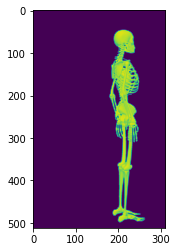

In [ ]:
print(img_arr.shape)
plt.imshow(img_arr)

## **Utils**

In [ ]:
# GIVEN INPUT IMAGE PATH, RETURNS FLATTENED VECTOR
def get_img_vector(path, size):
    img = (PIL.Image.open(path).convert('L')).crop((500, 250, 1500, 1898))
    img.thumbnail((size,size))
    imgarr = np.array(img)
    return (imgarr.reshape(-1).tolist())

def show_img_vector(vector , title, ax=None ,figsize=(4,4), size=(256,155)):
    if(ax):
        ax.set_title(title)
        ax.imshow(np.reshape(vector,size))
    else:
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.imshow(np.reshape(vector,size))

## **Train vectors**

In [ ]:
train_df = pd.read_csv(ROOT/'data/train/train.csv')
display(train_df.tail(3))

# train_vectors_df = pd.read_pickle(ROOT/'data/train/train_vectors.pkl')
# display(train_vectors_df.tail(3)) # train_vectors_df.iloc[:,1] - vectors256

,filename,xRot
9996,009996.png,193.035309
9997,009997.png,110.169956
9998,009998.png,188.274024


## **Index**

In [ ]:
f = len(train_vectors_df.vectors256[0])
t = AnnoyIndex(f, metric='angular')
print(f)

39680


In [ ]:
ntree = 2400

for i in tqdm(range(len(train_vectors_df.vectors256))):
    t.add_item(i, train_vectors_df.vectors256[i])

status = t.build(ntree)
print("[INFO] TREE BUILT: ",status)


[INFO] TREE BUILT:  True


In [ ]:
t.save(str(ROOT/'models/annoy_A-256-24.ann'))

True

## **Distribution**

In [ ]:
# CHECK DISTRIBUTION BETWEEN RANGE
sorted_train_df = train_df[train_df['xRot'].between(0,360)].sort_values(by='xRot')
sorted_train_df

,filename,xRot
8856,008856.png,1.181022
8520,008520.png,2.360807
8728,008728.png,3.003900
1528,001528.png,3.086963
6124,006124.png,3.247118
...,...,...
4748,004748.png,359.729037
1797,001797.png,359.744473
3621,003621.png,359.752993
3384,003384.png,359.787799


In [ ]:
discrete_train_df = pd.DataFrame(columns=['filename', 'xRot'])

for i in range(361):
    item = sorted_train_df.iloc[(sorted_train_df['xRot']-i).abs().argsort()[:1]]
    if(item.index[0] not in discrete_train_df.index):
        discrete_train_df = discrete_train_df.append(item)
display(discrete_train_df)

,filename,xRot
8856,008856.png,1.181022
8520,008520.png,2.360807
8728,008728.png,3.003900
6384,006384.png,4.056636
5149,005149.png,5.014371
...,...,...
1920,001920.png,356.029162
773,000773.png,356.995834
2729,002729.png,357.954404
1728,001728.png,358.993181


In [ ]:
distances_from_one = []
for row in tqdm(discrete_train_df.iterrows()):
    distances_from_one.append(t.get_distance(8856, row[0]))

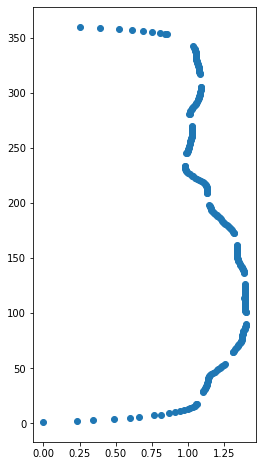

In [ ]:
plt.figure(figsize=(4,8))
plt.scatter(distances_from_one, discrete_train_df.xRot)

## **Evaluation**

In [ ]:
# #TEST FILENAMES
# test_df = pd.read_csv(ROOT/'data/test/test.csv')
# display(test_df.head(3))

#TRAIN TEST_VECTORS DF & ASSIGN VECTOR LIST
test_vectors_df = pd.read_pickle(ROOT/'data/test/test_vectors.pkl')
display(test_vectors_df.head(3))

,filename
0,009999.png
1,010000.png
2,010001.png


,filename,vectors256
0,009999.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,010000.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,010001.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# (IF NOT LOADED)
# LOAD INDEXED ANNOY MODEL 

f = 39680# len(test_vectors_df.vectors256[0])
t = AnnoyIndex(f, metric='angular')
print(f)

39680


In [ ]:
t.load('/content/skely/annoy_A-256-24.ann')

True

## **Final Predictions**

In [ ]:
# # USE TEST VECTOR DF
# final_preds = []
# final_results = []

# for vector in tqdm(test_vectors_df.vectors256):
#     result = t.get_nns_by_vector(vector, 10, include_distances=True)
#     final_results.append(result)
#     # mean = np.average(train_df.iloc[result,1].tolist())
#     # final_preds.append(round(mean, 3))

In [ ]:
# PRECALCULATED RESULTS
results_df = pd.read_pickle(ROOT/'data/results.pkl')
results_df.head()

,indices,A-distances
0,"[1284, 96, 206, 2510, 6600, 378, 7435, 5044, 7...","[0.02188986912369728, 0.026377510279417038, 0...."
1,"[8093, 3221, 1689, 4741, 2950, 1995, 9626, 319...","[0.3588942289352417, 0.36287328600883484, 0.36..."
2,"[9794, 1908, 1116, 1886, 8974, 6434, 5198, 573...","[0.038310203701257706, 0.040554534643888474, 0..."
3,"[6426, 8919, 1395, 965, 7301, 8604, 8399, 5164...","[0.006000981666147709, 0.0063381982035934925, ..."
4,"[284, 1654, 8260, 4147, 2588, 7274, 2283, 2853...","[0.0036882394924759865, 0.006104936823248863, ..."


In [ ]:
anchors = [1, 89, 181, 269]
anchors_idx = [8856, 9764, 5091, 8121]
final_preds = []

for i in tqdm(range(len(results_df))):
    sims = []
    for a in anchors_idx:
        sims.append(t.get_distance(a, results_df.indices[i][0]))
    print(sims)
    break

[1.1175768375396729, 1.3624491691589355, 1.1400622129440308, 1.2664568424224854]


### **Submission**

In [ ]:
answer = pd.DataFrame({'filename':test_df['filename'], 'xRot':final_preds})
answer.to_csv('submission_256A-24.csv', index=False)
answer.head()

,filename,xRot
0,009999.png,217.148
1,010000.png,197.747
2,010001.png,340.990
3,010002.png,125.371
4,010003.png,146.996


In [ ]:
from google.colab import files
files.download('submission_256A-24.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


## **Sanity Check**

In [ ]:
#ANCHORS
print(t.get_distance(8856, 5091)) #1, 181
print(t.get_distance(9764, 8121)) #89, 269
print(t.get_distance(7315,7789)) #29,209

1.2577005624771118
1.4142135381698608
0.9162320494651794


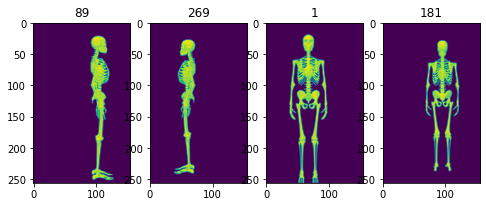

In [ ]:
# NEIGHBOUR FROM FOLDER
# 9764 - 89
# 8121 - 269
# 8856 - 1
# 5091 - 181

f, ax_arr = plt.subplots(ncols=4, figsize=(8,8))
vec = get_img_vector(ROOT/('data/train/train_images/009764.png'), 256)
show_img_vector(vec, "89", ax=ax_arr[0]) #89
vec = get_img_vector(ROOT/('data/train/train_images/008121.png'), 256)
show_img_vector(vec, "269", ax=ax_arr[1]) #269
vec = get_img_vector(ROOT/('data/train/train_images/008856.png'), 256)
show_img_vector(vec, "1", ax=ax_arr[2]) #1
vec = get_img_vector(ROOT/('data/train/train_images/005091.png'), 256)
show_img_vector(vec, "181", ax=ax_arr[3]) #181

217.0787150408698


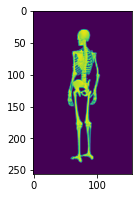

In [ ]:
# TEST SINGLE IMAGE
test = get_img_vector(ROOT/'data/test/test_images/009999.png', 256)
show_img_vector(test , "", figsize=(3,3))

res = t.get_nns_by_vector(test, 6, include_distances=True)
print(np.average(train_df.iloc[res[0],1].tolist()))

In [ ]:
# CHECK PROXIMITY TO ANCHORS
print(t.get_distance(res[0][0],9764)) #(res0) , 89
print(t.get_distance(res[0][0],8121)) #(res0) , 269
print("")
print(t.get_distance(res[0][0],8856)) #(res0) , 1
print(t.get_distance(res[0][0],5091)) #(res0) , 181

1.3624491691589355
1.2664568424224854

1.1175768375396729
1.1400622129440308


In [ ]:
print(res)
train_df.iloc[res[0],]

([1284, 96, 206, 2510, 6600, 378], [0.02188986912369728, 0.026377510279417038, 0.042648330330848694, 0.04651026055216789, 0.049699567258358, 0.06511353701353073])


,filename,xRot
1284,001284.png,216.916610
96,000096.png,217.082995
206,000206.png,216.818959
2510,002510.png,217.177858
6600,006600.png,217.199019
378,000378.png,217.276849


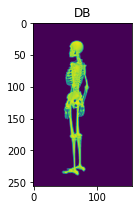

In [ ]:
# CHECK NEIGHBOUR FROM WITHIN DB
vec = t.get_item_vector(res[0][0]) #res0
show_img_vector(vec, "DB", figsize=(3,3))

## **Utils**  - for vector creation

### For train_vectors

In [ ]:
#RETURNS LIST OF TRAIN VECTORS
train_vectors = []
count = -1

for filename in tqdm(train_df['filename']):
    count+=1
    if (count%1000 == 0):
        print('[INFO] ITER: ', count, '  FILE:', filename)

    path = ROOT/('data/train/train_images/'+filename)
    train_vectors.append(img_arr_generator(path, '''SIZE'''))

len(train_vectors)

### For test_vectors

In [ ]:
#RETURNS LIST OF TRAIN VECTORS AND PREDICTIONS / CONVERT TO DF
final_filenames = []
final_preds = []
test_vectors = []

for filename in tqdm(test_df['filename']):
    path = ROOT/('data/test/test_images/'+filename)
    vec = img_arr_generator(path, 256)
    result = t.get_nns_by_vector(vec, 5)
    mean = np.average(train_df.iloc[result,1].tolist())

    test_vectors.append(vec)
    final_preds.append(round(mean, 6))
    final_filenames.append(path.name)